# Mentium Take Home Test

## Challenge Specification

1. Create a simple convolutional network (with 3-5 total layers) to classify MNIST dataset.
2. Set up the training and validation flow and train the network on the MNIST dataset.
3. Calculate the network classification performance on the validation and training datasets.
4. Calculate the network size in Kbytes.
5. Perform an 8-bit post-training quantization of the trained network and recalculate the network
size in KB and its classification performance.
6. Perform an 8-bit quantization-aware training on the original network and recalculate the network
size in KB and its classification performance after the network is trained.

Each task in this spec is marked as [<TASK_NUMBER>] in the code below.

## Considerations and Constraints

1. I am opting to use ready-made library to handle the dataset.
2. I am opting to use PyTorch as required to build the model.
3. All quantization will be done using PyTorch quantization tools only.
4. I am opting to not implement early stopping. This requires selection of the parameter to be emphasized.

In [1]:
# Imports

import os
import json
import torch
import torch.nn as nn

torch.manual_seed(0)

from torchvision.datasets import MNIST
from torchvision import transforms
from sklearn.model_selection import KFold

import torch.utils
import torch.utils.data

from tqdm.notebook import tqdm

import copy

# Quantization
import torch.ao.quantization

In [2]:
# Configuration

FP32_TRAIN_EPOCHS = 10
BATCH_SIZE = 64
CROSS_VALIDATION_FOLDS = 5
LEARNING_RATE = 0.0001
FINE_LOG_INTERVAL = 1000
FINE_LOG_OUT = False
QUANTIZATION_TRAIN_EPOCHS = 5

## Model Architecture

[1]

In [3]:
# If batch size is large(I believe the threshold where it becomes necessary for this model would be 128/256), then batchnorm must be used.

class MNISTClassifier(nn.Module):
    def __init__(self):
        super(MNISTClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.relu1 = nn.ReLU()
        
        self.maxpool_pad = nn.MaxPool2d(2, padding=1)
        
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.relu2 = nn.ReLU()
        
        self.maxpool = nn.MaxPool2d(2)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.relu3 = nn.ReLU()
        
        self.fc1 = nn.Linear(128 * 4 * 4, 128)
        self.fc2 = nn.Linear(128, 10)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        
        x = self.maxpool_pad(x)
        
        x = self.conv2(x)
        x = self.relu2(x)
        
        x = self.maxpool_pad(x)
        
        x = self.conv3(x)
        x = self.relu3(x)
        
        x = self.maxpool(x)
        
        # print(x.shape)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x
    
    def predict(self, x):
        with torch.no_grad():
            return torch.argmax(self.forward(x), 1)

## Data Preparation

In [4]:
transforms_ = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

dataset = MNIST(root='data', download=True, transform=transforms_)

# Cross Validation Split
kfold = KFold(n_splits=CROSS_VALIDATION_FOLDS, shuffle=True)

## Training Loop

In [5]:
# Globals to store the best model
best_params = {
    'model': None,
    'accuracy': 0,
    'epoch': 0,
    'fold': 0,
    'training_acc': None,
    'val_acc': None
}

[2], [3]

In [6]:
# Updated train and test functions with kfold

import torch.utils.data.dataloader

if not os.path.exists('checkpoints'):
    os.makedirs('checkpoints')

def reset_model_params(model):
    for layer in model.children():
        if hasattr(layer, 'reset_parameters'):
            layer.reset_parameters()

def train(model, train_loader, loss_fn, device):
    model.train()
    model.to(device)
    for i, data in enumerate(train_loader):
            X, y = data
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_pred = model(X)
            loss = loss_fn(y_pred, y)
            loss.backward()
            optimizer.step()
            loss_val = loss.item()
            
            if (i % FINE_LOG_INTERVAL == 0) and FINE_LOG_OUT:
                print(f"Loss: {loss_val}")
                
    return loss_val
        
def validate(model, test_loader, loss_fn, device):
    model.eval()
    for X, y in test_loader:
        X, y = X.to(device), y.to(device)
        y_pred = model.forward(X)
        loss = loss_fn(y_pred, y)
    val_loss = loss.item()
    return val_loss

def test_acc(model, test_loader, device):
    # Validation
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)
            y_pred = model.predict(X)
            correct += torch.sum(y_pred == y).item()
            total += y.size(0)
        accuracy = correct / total
        # print(f"Accuracy: {accuracy}")
        
    return accuracy

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

for fold, (train_idx, test_idx) in (fold_pbar := tqdm(
    enumerate(kfold.split(dataset)), 
    total=CROSS_VALIDATION_FOLDS, 
    position=0,
    desc="Folds")):
    # print(f"Fold {fold}")
    sample_train, sample_test = torch.utils.data.SubsetRandomSampler(train_idx), torch.utils.data.SubsetRandomSampler(test_idx)
    
    train_loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, sampler=sample_train)
    test_loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, sampler=sample_test)
    
    model = MNISTClassifier()
    if torch.cuda.is_available():
        model.cuda()
    model.apply(reset_model_params)
    
    loss_fn = nn.NLLLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    
    for epoch in (epoch_pbar := tqdm(
        range(FP32_TRAIN_EPOCHS), 
        position=1, 
        desc="Epochs (Fold - {})".format(fold),
        )):
        # print(f"Epoch {epoch}")
        loss_val = train(model, train_loader, loss_fn, device=device)
        val_loss = validate(model, test_loader, loss_fn=loss_fn, device=device)
        val_acc = test_acc(model, test_loader, device=device)
        
        epoch_pbar.set_postfix({
            'Loss': loss_val,
            'Val Loss': val_loss,
            'Val Acc': val_acc
        })
      
        if best_params['val_acc'] is None or val_acc > best_params['val_acc'] :
            best_params['model'] = model
            best_params['epoch'] = epoch
            best_params['fold'] = fold
            best_params['training_loss'] = loss_val
            best_params['val_loss'] = val_loss
            best_params['val_acc'] = val_acc  
            
            # epoch_pbar.set_postfix({
            #     'Best Accuracy': best_params['val_acc'],
            #     'Best Epoch': best_params['epoch']
            # })

print("Best Model : ")
print(json.dumps({k:best_params[k] for k in best_params.keys() if 'model' not in k}, indent=4))

# Save the best model
torch.save(best_params['model'].state_dict(), f"checkpoints/best_model.pth")

Folds:   0%|          | 0/5 [00:00<?, ?it/s]

Epochs (Fold - 0):   0%|          | 0/10 [00:00<?, ?it/s]

Epochs (Fold - 1):   0%|          | 0/10 [00:00<?, ?it/s]

Epochs (Fold - 2):   0%|          | 0/10 [00:00<?, ?it/s]

Epochs (Fold - 3):   0%|          | 0/10 [00:00<?, ?it/s]

Epochs (Fold - 4):   0%|          | 0/10 [00:00<?, ?it/s]

Best Model : 
{
    "accuracy": 0,
    "epoch": 9,
    "fold": 4,
    "training_acc": null,
    "val_acc": 0.9860833333333333,
    "training_loss": -0.9844926595687866,
    "val_loss": -0.9998673796653748
}


Cross validation is only meant to validate the model. 
I choose to pick the best model based on the validation accuracy since that instance of the model likely is the best possibility.

## Network Size Calculation

1. The network size will be calculated using the `torchsummary` library. While this is not extremely difficult to implement, I am opting to use the library to save time.
2. The network size will be calculated in KBytes.

NOTE: This library does not support quantized models. The weights calculation functions is implemented later in the file.

[4] - Partial - Please look for the next [4] for the full implementation.


In [7]:
import torchinfo

summary = torchinfo.summary(model, input_size = (1, 1, 28, 28))
print(summary)

Layer (type:depth-idx)                   Output Shape              Param #
MNISTClassifier                          [1, 10]                   --
├─Conv2d: 1-1                            [1, 32, 28, 28]           320
├─ReLU: 1-2                              [1, 32, 28, 28]           --
├─MaxPool2d: 1-3                         [1, 32, 15, 15]           --
├─Conv2d: 1-4                            [1, 64, 15, 15]           18,496
├─ReLU: 1-5                              [1, 64, 15, 15]           --
├─MaxPool2d: 1-6                         [1, 64, 8, 8]             --
├─Conv2d: 1-7                            [1, 128, 8, 8]            73,856
├─ReLU: 1-8                              [1, 128, 8, 8]            --
├─MaxPool2d: 1-9                         [1, 128, 4, 4]            --
├─Linear: 1-10                           [1, 128]                  262,272
├─Linear: 1-11                           [1, 10]                   1,290
├─Softmax: 1-12                          [1, 10]                   -

## Quantization

### Post-Training Quantization [5]

In [8]:
import torch.ao.quantization

# NOTE: This is not working as expected due to pytorch expecting the dequant to precede the softmax layer 
# class MNISTClassificationPostTrainingStatic(MNISTClassifier):
#     def __init__(self, model_file):
#         super(MNISTClassificationPostTrainingStatic, self).__init__()
#         self.quant = torch.ao.quantization.QuantStub()
#         self.dequant = torch.ao.quantization.DeQuantStub()
#         self.model = MNISTClassifier()
#         self.model.load_state_dict(torch.load(model_file))
        
#     def forward(self, x):
#         x = self.quant(x)
#         x = self.model(x)
#         x = self.dequant(x)
#         return x
    
#     def predict(self, x):
#         with torch.no_grad():
#             return torch.argmax(self.forward(x), 1)

class MNISTClassificationQuantize(nn.Module):
    def __init__(self, weight_path) -> None:
        super(MNISTClassificationQuantize, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.relu1 = nn.ReLU() # Cannot use the same relu layer as the quantization expects the relu to be fused with the conv layer
        
        self.maxpool_pad = nn.MaxPool2d(2, padding=1)
        
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.relu2 = nn.ReLU()
        
        self.maxpool = nn.MaxPool2d(2)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.relu3 = nn.ReLU()
        
        self.fc1 = nn.Linear(128 * 4 * 4, 128)
        self.fc2 = nn.Linear(128, 10)
        self.softmax = nn.Softmax(dim=1)
        
        self.quant = torch.ao.quantization.QuantStub()
        self.dequant = torch.ao.quantization.DeQuantStub()
        
        self.load_state_dict(torch.load(weight_path))
        
    def forward(self, x):
        x = self.quant(x)
        x = self.conv1(x)
        x = self.relu1(x)
        
        x = self.maxpool_pad(x)
        
        x = self.conv2(x)
        x = self.relu2(x)
        
        x = self.maxpool_pad(x)
        
        x = self.conv3(x)
        x = self.relu3(x)
        
        x = self.maxpool(x)
        
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.dequant(x)
        x = self.softmax(x)
        return x
    
    def predict(self, x):
        with torch.no_grad():
            return torch.argmax(self.forward(x), 1)
        
model_fp32 = MNISTClassificationQuantize('checkpoints/best_model.pth')

model_fp32.eval()
model_fp32.qconfig = torch.ao.quantization.get_default_qconfig('x86')
model_fp32_fused = torch.ao.quantization.fuse_modules(
    model_fp32, [
        ['conv1', 'relu1'], 
        ['conv2', 'relu2'], 
        ['conv3', 'relu3']
        ])
model_fp32_prepared = torch.ao.quantization.prepare(model_fp32_fused)

# The model needs to be run on valid data to record the quantization parameters.
# Running it on random data will yield extremely poor results

for t_index, (X, y) in enumerate(train_loader):
    model_fp32_prepared(X)
    if t_index == 100:
        break

model_int8_quantized_ptsq = torch.ao.quantization.convert(model_fp32_prepared)

res = model_int8_quantized_ptsq(torch.rand(1, 1, 28, 28))

/media/thameem/data1/workspace/mentium_takehome/venv/lib/python3.11/site-packages/torch/ao/quantization/observer.py:220: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(


ONNX Exports

I prefer ONNX models to better understand the model structure and to be able to use the model in other frameworks. 

In [9]:
best_model_fp32 = MNISTClassifier()
best_model_fp32.load_state_dict(torch.load('checkpoints/best_model.pth'))
torch.onnx.export(
    best_model_fp32,
    torch.rand(1, 1, 28, 28),
    'model_fp32.onnx',
    export_params=True,
)
torch.save(model.state_dict(), 'model_best_fp32.pth')

In [10]:
torch.onnx.export(
    model_int8_quantized_ptsq,
    torch.randn(1, 1, 28, 28),
    'model_int8_ptsq_quantized.onnx',
    export_params=True,
)
torch.save(model_int8_quantized_ptsq.state_dict(), 'model_int8_quantized_ptsq.pth')

## QAT - Quantization Aware Training

 - As with the post-training quantization, I will use the PyTorch quantization tools to perform the quantization aware training.
 - The quantization aware training is best done as a fine-tune step rather than training from scratch.

[6]

In [11]:
# Quantization Aware Training

model_fp32 = MNISTClassificationQuantize('checkpoints/best_model.pth')
model_fp32.train()
model_fp32.qconfig = torch.ao.quantization.get_default_qconfig('x86')
model_fp32_fused = torch.ao.quantization.fuse_modules(
    model_fp32, [
        ['conv1', 'relu1'], 
        ['conv2', 'relu2'], 
        ['conv3', 'relu3']
        ])
model_fp32_qat_prepared = torch.ao.quantization.prepare_qat(model_fp32_fused)

qat_best_params = {
    'accuracy': 0,
    'epoch': 0,
    'fold': 0,
    'training_acc': None,
    'val_acc': None
}

qat_device = torch.device('cpu') # Choosing CPU for now

qat_best_model = None

# K Fold not needed as we are using the best model
for epoch in (qat_pbar := tqdm(range(QUANTIZATION_TRAIN_EPOCHS), desc="QAT Epochs", position=0)):
    loss_val = train(model_fp32_qat_prepared, train_loader, loss_fn, device=qat_device)
    val_loss = validate(model_fp32_qat_prepared, test_loader, loss_fn=loss_fn, device=qat_device)
    val_acc = test_acc(model_fp32_qat_prepared, test_loader, device=qat_device)
    
    if qat_best_params['val_acc'] is None or val_acc > qat_best_params['val_acc'] :
        qat_best_model = copy.deepcopy(model_fp32_qat_prepared) # This works as the model is tiny. For much larger models, it'd best to save the state_dict to disk and track that only
        qat_best_params['epoch'] = epoch
        qat_best_params['fold'] = fold
        qat_best_params['training_loss'] = loss_val
        qat_best_params['val_loss'] = val_loss
        qat_best_params['val_acc'] = val_acc
        
        qat_pbar.set_postfix({
            'Best Accuracy': qat_best_params['val_acc'],
            'Best Epoch': qat_best_params['epoch']
        })
        
print("Best Model : ")
print(json.dumps({k:qat_best_params[k] for k in qat_best_params.keys() if 'model' not in k}, indent=4))

# Save the best model
torch.save(qat_best_model.state_dict(), f"checkpoints/qat_best_model_fp32.pth")

model_fp32_qat_prepared.eval()
model_int8 = torch.ao.quantization.convert(model_fp32_qat_prepared)

inp_fp32 = torch.randn(1, 1, 28, 28)
res = model_int8(inp_fp32)

# Export ONNX
torch.onnx.export(
    model_int8,
    torch.randn(1, 1, 28, 28),
    'model_int8_qat_quantized.onnx',
    export_params=True,
)
torch.save(model_int8.state_dict(), 'model_int8_qat_quantized.pth')

QAT Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Best Model : 
{
    "accuracy": 0,
    "epoch": 0,
    "fold": 4,
    "training_acc": null,
    "val_acc": 0.9860833333333333,
    "training_loss": -0.97747802734375,
    "val_loss": -0.9649658203125
}


## Network Size Calculation - Updated

In [12]:

def calculate_model_size(model : nn.Module):
    model_size = 0
    for param in model.parameters():    
        model_size += param.numel() * param.element_size()
    return model_size

def calculate_quantized_model_size(model):
    # This only considers the weights and not the biases. That is why the size is smaller
    # than the model file size.
    model_int8_size = 0
    weights = model.state_dict()
    for key in weights:
        if 'weight' in key:
            weight_tensor : torch.Tensor = weights[key]
            model_int8_size += weight_tensor.numel() * weight_tensor.element_size()
            
        if ('packed_params' in key and 'dtype' not in key):
            for ele in weights[key]:
                if isinstance(ele, torch.Tensor):
                    model_int8_size += ele.numel() * ele.element_size()
                if isinstance(ele, torch.nn.Parameter):
                    model_int8_size += ele.numel() * ele.element_size()
        # model_int8_size += weights[key].numel() * weights[key].element_size()
    return model_int8_size


model_fp32_size = calculate_model_size(model_fp32)
model_int8_quantized_ptsq_size = calculate_quantized_model_size(model_int8_quantized_ptsq)
model_int8_size = calculate_quantized_model_size(model_int8)

print("FP32 Model size : ", model_fp32_size / 1024, "Kbytes")
print("Quantized INT8 Model size : ", model_int8_size / 1024, "Kbytes")

FP32 Model size :  1391.5390625 Kbytes
Quantized INT8 Model size :  348.609375 Kbytes


In [13]:
# Accuracy comparison

fp32_acc = test_acc(model, test_loader, device)
int8_ptsq_acc = test_acc(model_int8_quantized_ptsq, test_loader, torch.device('cpu'))
int8_qat_acc = test_acc(model_int8, test_loader, torch.device('cpu'))

print("FP32 Accuracy : ", fp32_acc)
print("INT8 PTSQ Accuracy : ", int8_ptsq_acc)
print("INT8 QAT Accuracy : ", int8_qat_acc)

print("PTSQ Loss in Accuracy : ", ((fp32_acc - int8_ptsq_acc )/ fp32_acc) * 100, "%")
print("QAT Loss in Accuracy : ", ((fp32_acc - int8_qat_acc )/ fp32_acc) * 100, "%")

FP32 Accuracy :  0.9860833333333333
INT8 PTSQ Accuracy :  0.98525
INT8 QAT Accuracy :  0.9853333333333333
PTSQ Loss in Accuracy :  0.08450942280064423 %
QAT Loss in Accuracy :  0.07605848052058092 %


### Size Difference - Visualization

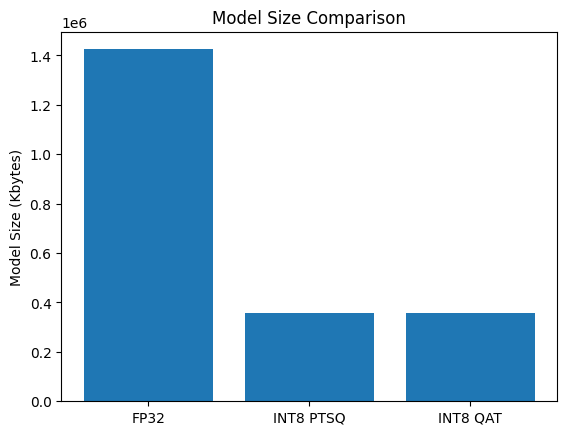

In [14]:
import matplotlib.pyplot as plt

plt.bar(['FP32', 'INT8 PTSQ', 'INT8 QAT'], [model_fp32_size, model_int8_quantized_ptsq_size, model_int8_size])
plt.ylabel('Model Size (Kbytes)')
plt.title('Model Size Comparison')
plt.show()

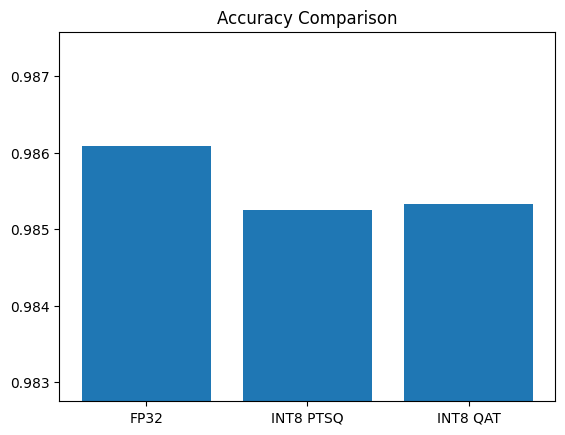

In [24]:

plt.bar(['FP32', 'INT8 PTSQ', 'INT8 QAT'], [fp32_acc, int8_ptsq_acc, int8_qat_acc])
plt.ylim(min([fp32_acc, int8_ptsq_acc, int8_qat_acc])-0.0025, max([fp32_acc, int8_ptsq_acc, int8_qat_acc]) + 0.0015)
plt.title("Accuracy Comparison")
plt.show()

PTSQ performance is quite dependant on the model architecture and the volume of data that is provided for the quantization stubs to observe.
While this model does not indicate the a great improvement in performance of QAT over , it is possible that a larger model with more data could show a sizeable improvement over PTSQ.